In [25]:
# loading needed methods
import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
from random import seed,sample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, roc_curve, auc,\
precision_score
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

In [26]:
data = pd.read_csv(r"E:\python projects\datasets\financial_dataset.csv")
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [27]:
data.shape

(6362620, 11)

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [29]:
data.describe().astype(int)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620,6362620,6362620,6362620,6362620,6362620,6362620,6362620
mean,243,179861,833883,855113,1100701,1224996,0,0
std,142,603858,2888242,2924048,3399180,3674128,0,0
min,1,0,0,0,0,0,0,0
25%,156,13389,0,0,0,0,0,0
50%,239,74871,14208,0,132705,214661,0,0
75%,335,208721,107315,144258,943036,1111909,0,0
max,743,92445516,59585040,49585040,356015889,356179278,1,1


In [30]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [31]:
data.duplicated().sum()

np.int64(0)

In [32]:
data["isFraud"].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [33]:
data['isFlaggedFraud'].value_counts()

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

In [34]:
# adding feature type1
data_new = data.copy() # creating copy of dataset in case I need original dataset
data_new["type1"] = np.nan # initializing feature column

# filling feature column
data_new.loc[data.nameOrig.str.contains('C') & data.nameDest.str.contains('C'),"type1"] = "CC" 
data_new.loc[data.nameOrig.str.contains('C') & data.nameDest.str.contains('M'),"type1"] = "CM"
data_new.loc[data.nameOrig.str.contains('M') & data.nameDest.str.contains('C'),"type1"] = "MC"
data_new.loc[data.nameOrig.str.contains('M') & data.nameDest.str.contains('M'),"type1"] = "MM"

data_new.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type1
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,CM
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,CM
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,CC
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,CC
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,CM


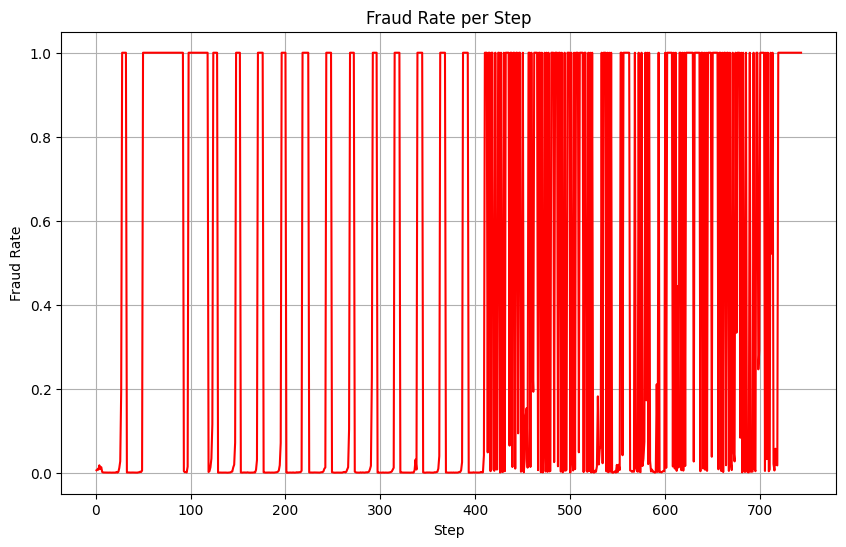

In [35]:
# Grouping by step and calculating fraud rate
fraud_rate_per_step = data_new.groupby('step')['isFraud'].mean()

# Plotting the fraud rate per step
plt.figure(figsize=(10, 6))
fraud_rate_per_step.plot(kind='line', color='red')
plt.title('Fraud Rate per Step')
plt.xlabel('Step')
plt.ylabel('Fraud Rate')
plt.grid()
plt.show()

In [36]:
# Subsetting data into observations with fraud and valid transactions:
fraud = data_new[data_new["isFraud"] == 1]
valid = data_new[data_new["isFraud"] == 0]

# seeing the counts of transactions by type1 (CC,CM,MC,MM)
print("Fraud transactions by type1: \n",fraud.type1.value_counts())
print("\n Valid transactions by type1: \n",valid.type1.value_counts())

Fraud transactions by type1: 
 type1
CC    8213
Name: count, dtype: int64

 Valid transactions by type1: 
 type1
CC    4202912
CM    2151495
Name: count, dtype: int64


In [37]:
total_fraud_amount = fraud['amount'].sum()
total_transaction_amount = data_new['amount'].sum()
total_valid_amount = total_transaction_amount - total_fraud_amount

print("Total amount of fraudulent transactions: \n",total_fraud_amount)
print("\n Total amount of valid transactions: \n",total_valid_amount)
print("\n Total amount of all transactions: \n",total_transaction_amount)

Total amount of fraudulent transactions: 
 12056415427.839998

 Total amount of valid transactions: 
 1132336529331.93

 Total amount of all transactions: 
 1144392944759.77


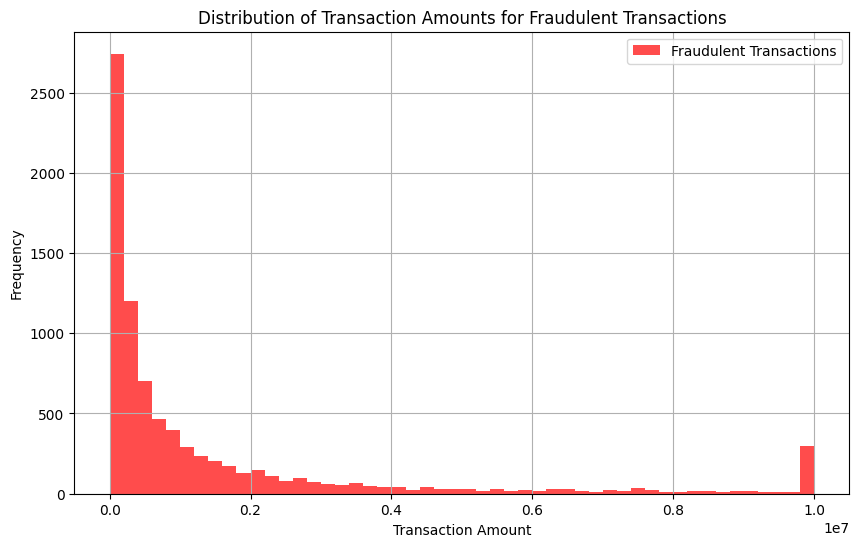

In [38]:
# Plotting the distribution of amounts for fraudulent transactions
plt.figure(figsize=(10, 6))
plt.hist(fraud['amount'], bins=50, color='red', alpha=0.7, label='Fraudulent Transactions')
plt.title('Distribution of Transaction Amounts for Fraudulent Transactions')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()

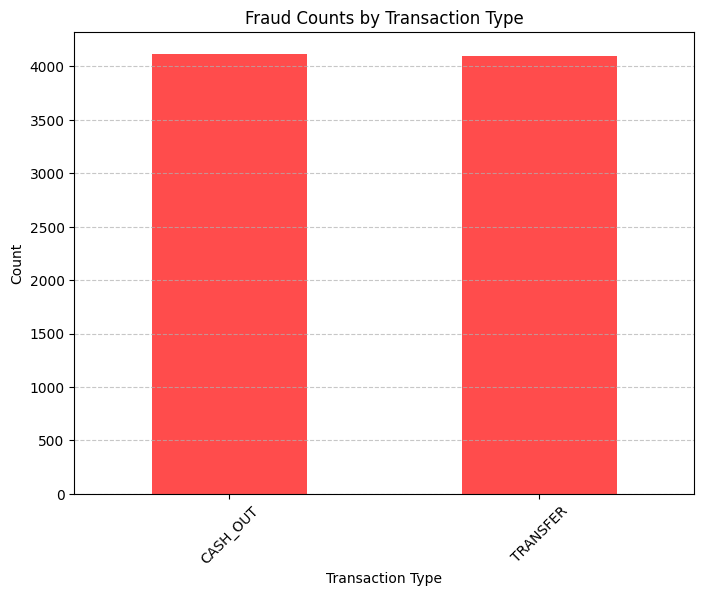

In [39]:
# Count the number of fraudulent transactions by type
fraud_counts_by_type = fraud['type'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(8, 6))
fraud_counts_by_type.plot(kind='bar', color='red', alpha=0.7)
plt.title('Fraud Counts by Transaction Type')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [40]:
# Top 5 fraudulent nameOrig
top_fraudulent_nameOrig = fraud['nameOrig'].value_counts().sort_values(ascending=False).head(5)

# Top 5 fraudulent nameDest
top_fraudulent_nameDest = fraud['nameDest'].value_counts().sort_values(ascending=False).head(5)

print("Top 5 fraudulent nameOrig:\n", top_fraudulent_nameOrig)
print("\nTop 5 fraudulent nameDest:\n", top_fraudulent_nameDest)

Top 5 fraudulent nameOrig:
 nameOrig
C1118430673    1
C1280323807    1
C1305486145    1
C840083671     1
C1420196421    1
Name: count, dtype: int64

Top 5 fraudulent nameDest:
 nameDest
C505532836     2
C964377943     2
C200064275     2
C1669818195    2
C1325541393    2
Name: count, dtype: int64


In [41]:
# getting rid of type1 column.
fraud = fraud.drop('type1', axis=1)
valid = valid.drop('type1',axis=1)
data_new = data_new.drop('type1',axis=1)

In [42]:
# seeing the counts of transactions by type
print("Fraud transactions by type: \n",fraud.type.value_counts())
print("\n Valid transactions by type: \n",valid.type.value_counts())

Fraud transactions by type: 
 type
CASH_OUT    4116
TRANSFER    4097
Name: count, dtype: int64

 Valid transactions by type: 
 type
CASH_OUT    2233384
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     528812
DEBIT         41432
Name: count, dtype: int64


In [43]:
# Subsetting data according to the conclusion above
# I don't have to subset for the fraud dataset because all of their transaction types are either TRANSFER or CASH_OUT

valid = valid[(valid["type"] == "CASH_OUT")| (valid["type"] == "TRANSFER")]
data_new = data_new[(data_new["type"] == "CASH_OUT") | (data_new["type"] == "TRANSFER")]


print("Valid transactions by type: \n",valid.type.value_counts())

Valid transactions by type: 
 type
CASH_OUT    2233384
TRANSFER     528812
Name: count, dtype: int64


In [44]:
wrong_orig_bal = sum(data["oldbalanceOrg"] - data["amount"] != data["newbalanceOrig"])
wrong_dest_bal = sum(data["newbalanceDest"] + data["amount"] != data["newbalanceDest"])
print("Percentage of observations with balance errors in the account giving money: ", 100*round(wrong_orig_bal/len(data),2))
print("Percentage of observations with balance errors in the account receiving money: ", 100*round(wrong_dest_bal/len(data),2))

Percentage of observations with balance errors in the account giving money:  85.0
Percentage of observations with balance errors in the account receiving money:  100.0


In [45]:
## Calculating some quantities to justify or reject some assumptions

# flatten the subsetted dataframe of floats into an array of floats
relevant_cols = data[["amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest"]].values.flatten()
# number of observations with negative numbers
num_neg_amt = sum(n < 0 for n in relevant_cols)
# number of observations where the amount given is greater than the amount that is in the giver's account
num_amt_oldgiver = sum(data["amount"] > data["oldbalanceOrg"]) 
# number of observations where the amount received is greater than the amount that is in the receiver's account
num_amt_newreceiver = sum(data["amount"] > data["newbalanceDest"]) 

print("number of observations with negative numbers: ", num_neg_amt)
print("number of observations where the amount given is greater than the amount that is in the giver's account: "
      , num_amt_oldgiver)
print("number of observations where the amount received is greater than the amount that is in the receiver's account: "
      , num_amt_newreceiver)

number of observations with negative numbers:  0
number of observations where the amount given is greater than the amount that is in the giver's account:  4079080
number of observations where the amount received is greater than the amount that is in the receiver's account:  2661141


In [46]:
# counting number of observations where oldbalanceOrg - amount != newbalanceOrig or newbalanceDest + amount != newbalanceDest
# Essentially, I am counting the number of observations where the effects of the transactions are not properly reflected
# the balances of account sending money and the account receiving money.

num_wrong_bal = (data["oldbalanceOrg"] - data["amount"] != data["newbalanceOrig"]) | (data["newbalanceDest"] + data["amount"] != data["newbalanceDest"])
print("Percentage of observations with balance errors: ", 100*round(sum(num_wrong_bal)/len(data),2))

Percentage of observations with balance errors:  100.0


In [47]:
# adding features errorBalanceOrg, errorBalanceDest
data_new["errorBalanceOrg"] = data_new.newbalanceOrig + data_new.amount - data_new.oldbalanceOrg
data_new["errorBalanceDest"] = data_new.oldbalanceDest + data_new.amount - data_new.newbalanceDest

# Subsetting data into observations with fraud and valid transactions:
fraud = data_new[data_new["isFraud"] == 1]
valid = data_new[data_new["isFraud"] == 0]

print("Summary statistics of errorBalanceOrg for fraudulent transactions: \n",fraud["errorBalanceOrg"].describe())
print("\n Summary statistics of errorBalanceOrg for valid transactions: \n",valid["errorBalanceOrg"].describe())

Summary statistics of errorBalanceOrg for fraudulent transactions: 
 count    8.213000e+03
mean     1.069233e+04
std      2.651461e+05
min     -7.450581e-09
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+07
Name: errorBalanceOrg, dtype: float64

 Summary statistics of errorBalanceOrg for valid transactions: 
 count    2.762196e+06
mean     2.868035e+05
std      8.763752e+05
min     -1.000000e-02
25%      5.261343e+04
50%      1.442008e+05
75%      2.804663e+05
max      9.244552e+07
Name: errorBalanceOrg, dtype: float64


In [48]:
print("Summary statistics of errorBalanceDest for fraudulent transactions: \n",fraud["errorBalanceDest"].describe())
print("\n Summary statistics of errorBalanceDest for valid transactions: \n",valid["errorBalanceDest"].describe())

Summary statistics of errorBalanceDest for fraudulent transactions: 
 count    8.213000e+03
mean     7.325093e+05
std      1.867748e+06
min     -8.875516e+06
25%      0.000000e+00
50%      2.231460e+03
75%      4.427220e+05
max      1.000000e+07
Name: errorBalanceDest, dtype: float64

 Summary statistics of errorBalanceDest for valid transactions: 
 count    2.762196e+06
mean    -3.091033e+04
std      5.840943e+05
min     -7.588573e+07
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.977761e+06
Name: errorBalanceDest, dtype: float64


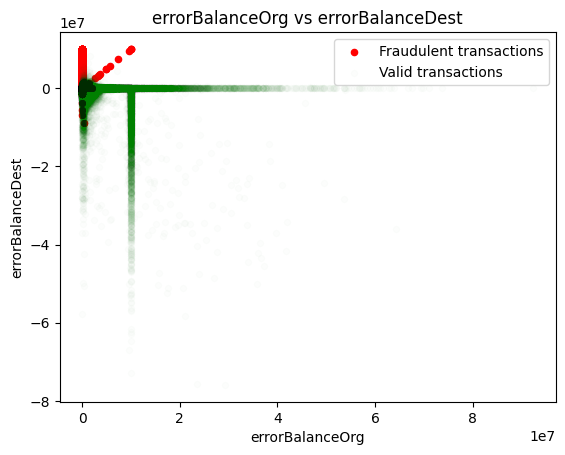

In [49]:
errors = ["errorBalanceOrg", "errorBalanceDest"]
ax = plt.subplot()

fplot = fraud.plot(x="errorBalanceOrg",y="errorBalanceDest",color="red",kind="scatter",ax=ax,label="Fraudulent transactions")
vplot = valid.plot(x="errorBalanceOrg",y="errorBalanceDest",color="green",kind="scatter",\
                   alpha=0.01,ax=ax,label="Valid transactions")
plt.title("errorBalanceOrg vs errorBalanceDest")
plt.show()

In [50]:
print("Proportion of fraudulent transactions with errorBalanceDest > 0: ", len(fraud[fraud.errorBalanceDest > 0])/len(fraud))
print("Proportion of valid transactions with errorBalanceDest > 0: ", len(valid[valid.errorBalanceDest > 0])/len(valid))
print("Proportion of fraudulent transactions with errorBalanceOrg > 0: ", len(fraud[fraud.errorBalanceOrg > 0])/len(fraud))
print("Proportion of valid transactions with errorBalanceOrg > 0: ", len(valid[valid.errorBalanceOrg > 0])/len(valid))

Proportion of fraudulent transactions with errorBalanceDest > 0:  0.5712894192134421
Proportion of valid transactions with errorBalanceDest > 0:  0.19744942067832985
Proportion of fraudulent transactions with errorBalanceOrg > 0:  0.006331425788384269
Proportion of valid transactions with errorBalanceOrg > 0:  0.9067180605576143


In [51]:
print("Fraud transactions by type: \n",fraud.type.value_counts())

Fraud transactions by type: 
 type
CASH_OUT    4116
TRANSFER    4097
Name: count, dtype: int64


In [52]:
# separating transfers and cashouts for fraud accounts

fraud_transfer = fraud[fraud["type"] == "TRANSFER"]
fraud_cashout = fraud[fraud["type"] == "CASH_OUT"]

# checking if the recipient account of a fraudulent transfer was used as a sending account for cashing out 
fraud_transfer.nameDest.isin(fraud_cashout.nameOrig).any()

np.False_

In [53]:
# getting rid of nameOrig and nameDest column.
names = ["nameOrig","nameDest"]
fraud = fraud.drop(names,axis= 1)
valid = valid.drop(names,axis=1)
data_new = data_new.drop(names,axis=1)

In [54]:
# how many observations were flagged as Fraud?
flagged = data_new[data_new["isFlaggedFraud"] == 1]
flagged_correctly = sum(flagged["isFraud"] == 1)
flagged_wrongly = len(flagged) - flagged_correctly
total = flagged_correctly + flagged_wrongly
print(flagged_correctly," observations were flagged correctly and ", flagged_wrongly, \
      " observations were flagged wrongly for a total of ", total, " flagged observations.")

# how many observations where the transaction is fraudulent, the transaction is a transfer and the amount is greater 
# than 200, 000 are in the dataset
should_be_flagged = fraud[(fraud["amount"] > 200000) & (fraud["type"] == "TRANSFER")]
print("number of observations that should be flagged: ",len(should_be_flagged))

16  observations were flagged correctly and  0  observations were flagged wrongly for a total of  16  flagged observations.
number of observations that should be flagged:  2740


In [55]:
# dropping isFlaggedFraud column from the fraud,valid, and new_data datasets

fraud = fraud.drop("isFlaggedFraud",axis=1)
valid = valid.drop("isFlaggedFraud",axis=1)
data_new = data_new.drop("isFlaggedFraud",axis=1)

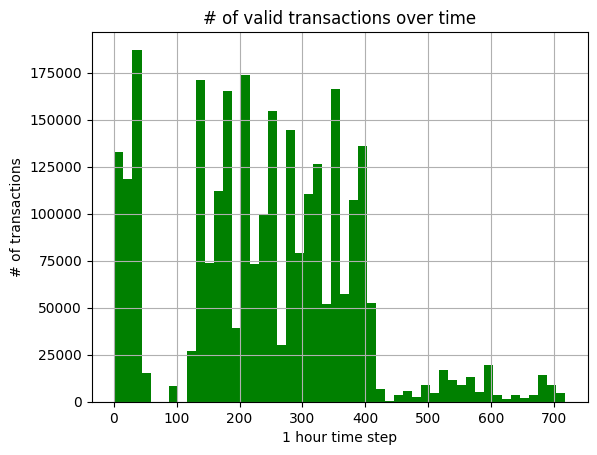

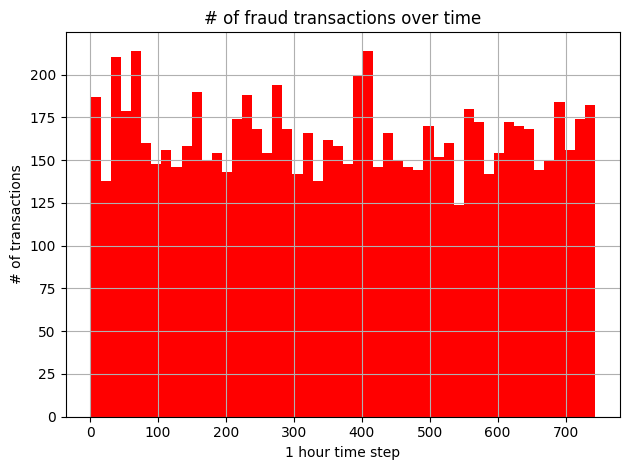

In [56]:
# Time patterns

bins = 50

valid.hist(column="step",color="green",bins=bins)
plt.xlabel("1 hour time step")
plt.ylabel("# of transactions")
plt.title("# of valid transactions over time")

fraud.hist(column ="step",color="red",bins=bins)
plt.xlabel("1 hour time step")
plt.ylabel("# of transactions")
plt.title("# of fraud transactions over time")

plt.tight_layout()
plt.show()

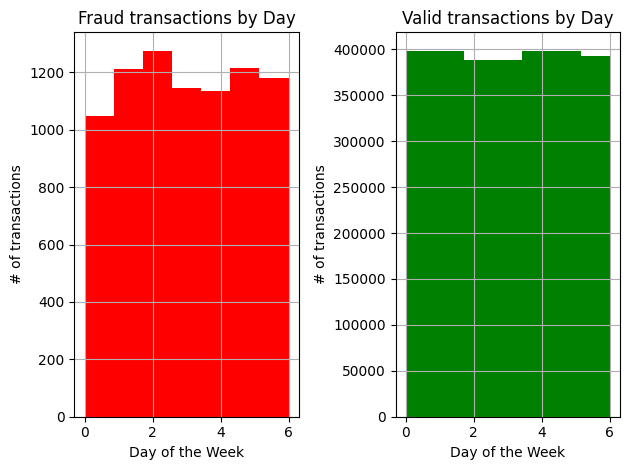

In [57]:
# getting hours and days of the week
num_days = 7
num_hours = 24
fraud_days = fraud.step % num_days
fraud_hours = fraud.step % num_hours
valid_days = valid.step % num_days
valid_hours = valid.step % num_hours

# plotting scatterplot of the days of the week, identifying the fraudulent transactions (red) from the valid transactions (green) 
plt.subplot(1, 2, 1)
fraud_days.hist(bins=num_days,color="red")
plt.title('Fraud transactions by Day')
plt.xlabel('Day of the Week')
plt.ylabel("# of transactions")

plt.subplot(1,2,2)
valid_days.hist(bins=num_days,color="green")
plt.title('Valid transactions by Day')
plt.xlabel('Day of the Week')
plt.ylabel("# of transactions")

plt.tight_layout()
plt.show()

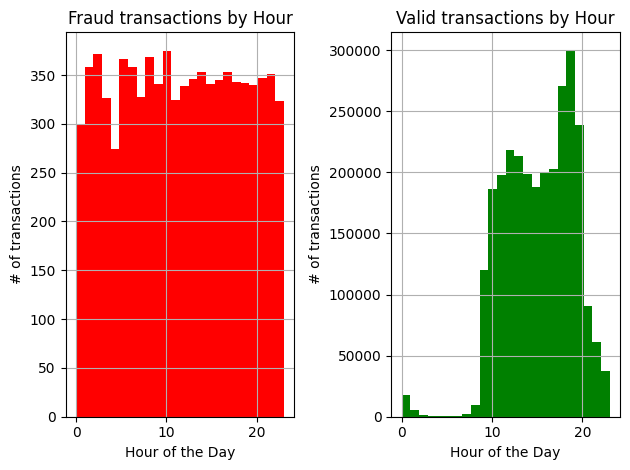

In [58]:
plt.subplot(1, 2, 1)
fraud_hours.hist(bins=num_hours, color="red")
plt.title('Fraud transactions by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel("# of transactions")


plt.subplot(1, 2, 2)
valid_hours.hist(bins=num_hours, color="green")
plt.title('Valid transactions by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel("# of transactions")

plt.tight_layout()
plt.show()

In [59]:
dataset1 = data_new.copy()


# adding feature HourOfDay to Dataset1 
dataset1["HourOfDay"] = np.nan # initializing feature column
dataset1.HourOfDay = data_new.step % 24


print("Head of dataset1: \n", dataset1.head())

Head of dataset1: 
     step      type     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
2      1  TRANSFER     181.00          181.0             0.0             0.0   
3      1  CASH_OUT     181.00          181.0             0.0         21182.0   
15     1  CASH_OUT  229133.94        15325.0             0.0          5083.0   
19     1  TRANSFER  215310.30          705.0             0.0         22425.0   
24     1  TRANSFER  311685.89        10835.0             0.0          6267.0   

    newbalanceDest  isFraud  errorBalanceOrg  errorBalanceDest  HourOfDay  
2             0.00        1             0.00             181.0          1  
3             0.00        1             0.00           21363.0          1  
15        51513.44        0        213808.94          182703.5          1  
19            0.00        0        214605.30          237735.3          1  
24      2719172.89        0        300850.89        -2401220.0          1  


In [60]:
# Seeing summary statistics of the data

print("Summary statistics on the amounts moved in fraudulent transactions: \n",pd.DataFrame.describe(fraud.amount),"\n")
print("Summary statistics on the amounts moved in valid transactions: \n", pd.DataFrame.describe(valid.amount),"\n")

Summary statistics on the amounts moved in fraudulent transactions: 
 count    8.213000e+03
mean     1.467967e+06
std      2.404253e+06
min      0.000000e+00
25%      1.270913e+05
50%      4.414234e+05
75%      1.517771e+06
max      1.000000e+07
Name: amount, dtype: float64 

Summary statistics on the amounts moved in valid transactions: 
 count    2.762196e+06
mean     3.141155e+05
std      8.771441e+05
min      1.000000e-02
25%      8.290823e+04
50%      1.710345e+05
75%      3.059942e+05
max      9.244552e+07
Name: amount, dtype: float64 



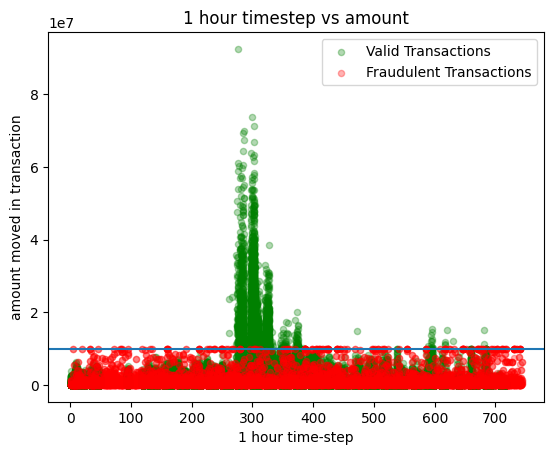

Proportion of transactions where the amount moved is greater than 10 million:  0.0008818192548464865


In [61]:
# plotting overlayed step vs amount scatter plots

alpha = 0.3
fig,ax = plt.subplots()
valid.plot.scatter(x="step",y="amount",color="green",alpha=alpha,ax=ax,label="Valid Transactions")
fraud.plot.scatter(x="step",y="amount",color="red",alpha=alpha,ax=ax, label="Fraudulent Transactions")

plt.title("1 hour timestep vs amount")
plt.xlabel("1 hour time-step")
plt.ylabel("amount moved in transaction")
plt.legend(loc="upper right")

# plotting a horizontal line to show where valid transactions behave very differently from fraud transactions

plt.axhline(y=10000000)
plt.show()


print("Proportion of transactions where the amount moved is greater than 10 million: ", \
      len(data_new[data_new.amount > 10000000])/len(data_new))

In [62]:
# finalizing dataset
dataset = dataset1.copy() # unchanged dataset1
dataset.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,errorBalanceOrg,errorBalanceDest,HourOfDay
2,1,TRANSFER,181.00,181.0,0.0,0.0,0.00,1,0.00,181.0,1
3,1,CASH_OUT,181.00,181.0,0.0,21182.0,0.00,1,0.00,21363.0,1
15,1,CASH_OUT,229133.94,15325.0,0.0,5083.0,51513.44,0,213808.94,182703.5,1
19,1,TRANSFER,215310.30,705.0,0.0,22425.0,0.00,0,214605.30,237735.3,1
24,1,TRANSFER,311685.89,10835.0,0.0,6267.0,2719172.89,0,300850.89,-2401220.0,1


In [63]:
# getting one-hot encoding of the 'type' variable

dataset = pd.get_dummies(data=dataset,prefix=['type'])
pd.DataFrame.head(dataset)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,errorBalanceOrg,errorBalanceDest,HourOfDay,type_CASH_OUT,type_TRANSFER
2,1,181.00,181.0,0.0,0.0,0.00,1,0.00,181.0,1,False,True
3,1,181.00,181.0,0.0,21182.0,0.00,1,0.00,21363.0,1,True,False
15,1,229133.94,15325.0,0.0,5083.0,51513.44,0,213808.94,182703.5,1,True,False
19,1,215310.30,705.0,0.0,22425.0,0.00,0,214605.30,237735.3,1,False,True
24,1,311685.89,10835.0,0.0,6267.0,2719172.89,0,300850.89,-2401220.0,1,False,True


In [64]:
dataset.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,errorBalanceOrg,errorBalanceDest,HourOfDay
count,2.770409e+06,2.770409e+06,2.770409e+06,2.770409e+06,2.770409e+06,2.770409e+06,2.770409e+06,2.770409e+06,2.770409e+06,2.770409e+06
mean,2.420081e+02,3.175361e+05,4.764308e+04,1.609190e+04,1.703551e+06,2.049734e+06,2.964544e-03,2.859850e+05,-2.864713e+04,1.530878e+01
std,1.416191e+02,8.877897e+05,2.513251e+05,1.512558e+05,4.225550e+06,4.676990e+06,5.436687e-02,8.753230e+05,5.934794e+05,4.004595e+00
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e-02,-7.588573e+07,0.000000e+00
25%,1.550000e+02,8.297354e+04,0.000000e+00,0.000000e+00,1.280734e+05,3.272891e+05,0.000000e+00,5.185310e+04,0.000000e+00,1.200000e+01
50%,2.360000e+02,1.712609e+05,3.039600e+02,0.000000e+00,5.557100e+05,8.280539e+05,0.000000e+00,1.435971e+05,0.000000e+00,1.600000e+01
75%,3.320000e+02,3.067912e+05,3.099700e+04,0.000000e+00,1.735900e+06,2.122198e+06,0.000000e+00,2.798912e+05,0.000000e+00,1.900000e+01
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,9.244552e+07,1.000000e+07,2.300000e+01


In [65]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2770409 entries, 2 to 6362619
Data columns (total 12 columns):
 #   Column            Dtype  
---  ------            -----  
 0   step              int64  
 1   amount            float64
 2   oldbalanceOrg     float64
 3   newbalanceOrig    float64
 4   oldbalanceDest    float64
 5   newbalanceDest    float64
 6   isFraud           int64  
 7   errorBalanceOrg   float64
 8   errorBalanceDest  float64
 9   HourOfDay         int64  
 10  type_CASH_OUT     bool   
 11  type_TRANSFER     bool   
dtypes: bool(2), float64(7), int64(3)
memory usage: 237.8 MB


In [66]:
# Setting random_state and seed so that the training/testing splits and model results are reproducible
RandomState = 42
seed(21)


# 42 is used often due to Hitchhiker's Guide to the Galaxy, I will use a number that a far smaller group may understand.
# Not that the actual number doesn't matter and is only used to make sure results are reproducible.
# creating training and testing sets
X = dataset.drop("isFraud",axis=1)
y = dataset.isFraud
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=RandomState)
    
# Normalizing data so that all variables follow the same scale (0 to 1)
scaler = StandardScaler()

# Fit only to the training data
scaler.fit(X_train)

# Now apply the transformations to the data:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [67]:
y_train.value_counts()

isFraud
0    2485953
1       7415
Name: count, dtype: int64

In [68]:
ncols = len(X.columns)
hidden_layers = (ncols,ncols,ncols)
max_iter = 1000
MLP = MLPClassifier(hidden_layer_sizes=hidden_layers,max_iter=1000,random_state=RandomState)

# training model
MLP.fit(X_train,y_train)
    
# evaluating model on how it performs on balanced datasets
predictionsMLP = MLP.predict(X_test)
CM_MLP = confusion_matrix(y_test,predictionsMLP)
CR_MLP = classification_report(y_test,predictionsMLP)
fprMLP, recallMLP, thresholdsMLP = roc_curve(y_test, predictionsMLP)
AUC_MLP = auc(fprMLP, recallMLP)
    
resultsMLP = {"Confusion Matrix":CM_MLP,"Classification Report":CR_MLP,"Area Under Curve":AUC_MLP}

In [69]:
# showing results from Multilayered perceptrons developed from each dataset
for measure in resultsMLP:
    print(measure,": \n",resultsMLP[measure])

Confusion Matrix : 
 [[276155     88]
 [   104    694]]
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    276243
           1       0.89      0.87      0.88       798

    accuracy                           1.00    277041
   macro avg       0.94      0.93      0.94    277041
weighted avg       1.00      1.00      1.00    277041

Area Under Curve : 
 0.9346778126776744


In [70]:
from sklearn.model_selection import GridSearchCV

parametersMLP = {'hidden_layer_sizes':[(ncols,ncols,ncols),(ncols,ncols),(ncols,)],'max_iter':[100,500,1000],\
                 'random_state':[RandomState]}
grid_search = GridSearchCV(estimator = MLP, param_grid = parametersMLP, cv = 10, n_jobs = -1)
grid_search.fit(X_train, y_train)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best Accuracy: 99.94 %
Best Parameters: {'hidden_layer_sizes': (11, 11), 'max_iter': 100, 'random_state': 42}


In [71]:
MLP = MLPClassifier(hidden_layer_sizes=best_parameters["hidden_layer_sizes"],max_iter=best_parameters["max_iter"],random_state= 42) 

# training model
MLP.fit(X_train,y_train)
    
# evaluating model on how it performs on balanced datasets
predictionsMLP = MLP.predict(X_test)
CM_MLP = confusion_matrix(y_test,predictionsMLP)
CR_MLP = classification_report(y_test,predictionsMLP)
fprMLP, recallMLP, thresholdsMLP = roc_curve(y_test, predictionsMLP)
AUC_MLP = auc(fprMLP, recallMLP)
    
resultsMLP = {"Confusion Matrix":CM_MLP,"Classification Report":CR_MLP,"Area Under Curve":AUC_MLP}

In [72]:
# showing results from Multilayered perceptrons developed from each dataset
for measure in resultsMLP:
    print(measure,": \n",resultsMLP[measure])

Confusion Matrix : 
 [[276222     21]
 [   147    651]]
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    276243
           1       0.97      0.82      0.89       798

    accuracy                           1.00    277041
   macro avg       0.98      0.91      0.94    277041
weighted avg       1.00      1.00      1.00    277041

Area Under Curve : 
 0.9078567268291818


In [73]:
# Train model
parametersRF = {'n_estimators':15,'oob_score':True,'class_weight': "balanced",'n_jobs':-1,\
                 'random_state':RandomState}
RF = RandomForestClassifier(**parametersRF)
fitted_vals = RF.fit(X_train, y_train)
 
# Predict on testing set
predictionsRF = RF.predict(X_test)
 
     
# Evaluating model
CM_RF = confusion_matrix(y_test,predictionsRF)
CR_RF = classification_report(y_test,predictionsRF)
fprRF, recallRF, thresholdsRF = roc_curve(y_test, predictionsRF)
AUC_RF = auc(fprRF, recallRF)

resultsRF = {"Confusion Matrix":CM_RF,"Classification Report":CR_RF,"Area Under Curve":AUC_RF}
# showing results from Random Forest

for measure in resultsRF:
    print(measure,": \n",resultsRF[measure])

Confusion Matrix : 
 [[276242      1]
 [     6    792]]
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    276243
           1       1.00      0.99      1.00       798

    accuracy                           1.00    277041
   macro avg       1.00      1.00      1.00    277041
weighted avg       1.00      1.00      1.00    277041

Area Under Curve : 
 0.9962387915031441



Receiver Operating Characteristic Curves for Random Forests and Extreme Gradient Boosted Trees: 


AUC of Random Forest: 
 0.9962387915031441


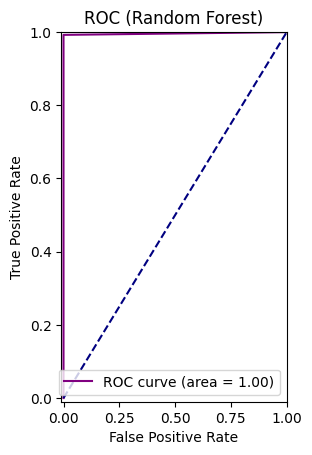

In [74]:

print("\nReceiver Operating Characteristic Curves for Random Forests and Extreme Gradient Boosted Trees: \n")
plt.subplot(1, 2, 1)
plt.plot(fprRF, recallRF, color='purple', label='ROC curve (area = %0.2f)' % AUC_RF)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (Random Forest)')
plt.legend(loc="lower right")




print("\nAUC of Random Forest: \n", AUC_RF)
